In [1]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  40.8M      0  0:00:01  0:00:01 --:--:-- 40.8M


### Now Preprocessing the dataset



In [2]:
import os, pathlib, shutil, random
from tensorflow import keras
import numpy as np

batch_size = 32
base_directory = pathlib.Path("/content/aclImdb")
training_review_dir = base_directory / "train"
validation_review_dir = base_directory / "val"

# Create validation dir and move 10,000 files per class
for category in ("neg", "pos"):
    os.makedirs(validation_review_dir / category, exist_ok=True)

    files = os.listdir(training_review_dir / category)
    random.Random(1496).shuffle(files)

    validation_sample_count = 10000
    validation_files = files[-validation_sample_count:]

    for review_file_name in validation_files:
        shutil.move(
            training_review_dir / category / review_file_name,
            validation_review_dir / category / review_file_name
        )

# Load datasets
train_review_dataset = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
).take(100)

validation_review_dataset = keras.utils.text_dataset_from_directory(
    "/content/aclImdb/val", batch_size=batch_size
)

test_review_dataset = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

te_only_train_review_dataset = train_review_dataset.map(lambda x, y: x)



Found 5000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


### Transforming text into numerical sequences

### **A sequence model developed using one-hot encoded vectors for the input sequences**

In [3]:
from tensorflow.keras import layers

MAX_SEQUENCE_LENGTH = 150   # Cutoff reviews after 150 words
MAX_VOCAB_SIZE = 10000      # Consider only the top 10,000 words

# Define TextVectorization layer
text_vectorization_layer = layers.TextVectorization(
    max_tokens=MAX_VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_SEQUENCE_LENGTH,
)

# Extract texts only from train_ds for vectorization adaptation
train_texts_only = train_review_dataset.map(lambda x, y: x)
text_vectorization_layer.adapt(train_texts_only)

# Vectorize the train, validation, and test datasets
vectorized_train_review_dataset = train_review_dataset.map(
    lambda x, y: (text_vectorization_layer(x), y),
    num_parallel_calls=4
)
vectorized_validation_review_dataset = validation_review_dataset.map(
    lambda x, y: (text_vectorization_layer(x), y),
    num_parallel_calls=4
)
int_test_review_dataset = test_review_dataset.map(
    lambda x, y: (text_vectorization_layer(x), y),
    num_parallel_calls=4
)


### **Define the Model with Embedding Layer**

### **We'll define the model with an embedding layer and pretrained word embedding before the Bidirectional layer**.

In [4]:
import tensorflow as tf  # Model with embedding layer

input_layer = keras.Input(shape=(None,), dtype="int64")
embedding_output = layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=256, mask_zero=True)(input_layer)
x = layers.Bidirectional(layers.LSTM(32))(embedding_output)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(input_layer, output_layer)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 256) │  2,560,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 64)        │     73,984 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         65 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

### Developing a fundamental sequencing concept initially

In [5]:
checkpoint_callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
]
# Ensure this is run before plotting
history = model.fit(vectorized_train_review_dataset, validation_data=vectorized_validation_review_dataset, epochs=15, callbacks=checkpoint_callbacks)


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.5312 - loss: 0.6888 - val_accuracy: 0.6576 - val_loss: 0.6228
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.7124 - loss: 0.5562 - val_accuracy: 0.7569 - val_loss: 0.5040
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.8261 - loss: 0.4072 - val_accuracy: 0.7904 - val_loss: 0.4500
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.8951 - loss: 0.2887 - val_accuracy: 0.7948 - val_loss: 0.4501
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.9136 - loss: 0.2198 - val_accuracy: 0.7793 - val_loss: 0.5282
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.9353 - loss: 0.1626 - val_accuracy: 0.7574 - val_loss: 0.5405
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.9723 - loss: 0.1100 - val_accuracy: 0.8001 - val_loss: 0.5318
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.9706 - loss: 0.0935 - val_ac

In [6]:
model = keras.models.load_model('one_hot_bidir_lstm.keras')
print(f"Test acc: {model.evaluate(int_test_review_dataset)[1]:.3f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.7890 - loss: 0.4539
Test acc: 0.786


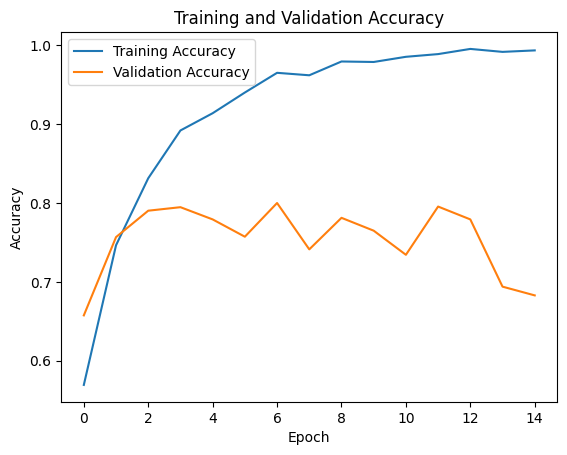

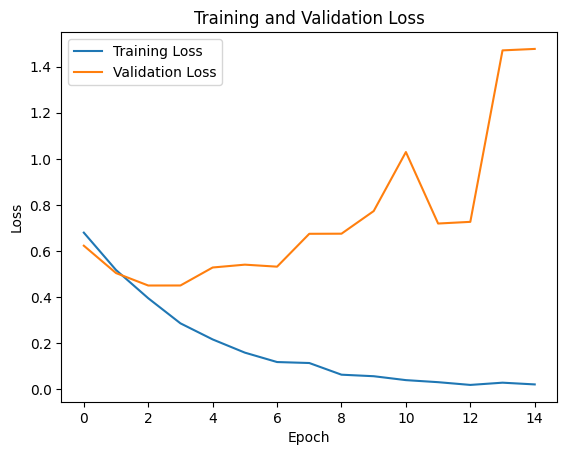

In [7]:

import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



### Utilizing the Embedding Layer for Word Vectorization

#### Applying the Embedding Mechanism in Practice


In [8]:
em_layer = layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=256)

#### Custom Embedding Layer System Built from Scratch

In [9]:
in1 = keras.Input(shape=(None,), dtype="int64")
em1 = layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=256)(in1)
x = layers.Bidirectional(layers.LSTM(32))(em1)
x = layers.Dropout(0.5)(x)
output_layer1 = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(in1, output_layer1)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, None, 256)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
checkpoint_callbacks1 = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",  # Change to .keras
                                    save_best_only=True)
]

history1 = model.fit(vectorized_train_review_dataset, validation_data=vectorized_validation_review_dataset, epochs=15, callbacks=checkpoint_callbacks1)

# Load the best model saved by the callback
model = keras.models.load_model("embeddings_bidir_gru.keras")

# Evaluate the model on the test dataset
print(f"Test acc: {model.evaluate(int_test_review_dataset)[1]:.3f}")


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5030 - loss: 0.6933 - val_accuracy: 0.6235 - val_loss: 0.6568
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.6537 - loss: 0.6286 - val_accuracy: 0.7506 - val_loss: 0.5358
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.7634 - loss: 0.5064 - val_accuracy: 0.7509 - val_loss: 0.5161
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.8266 - loss: 0.4108 - val_accuracy: 0.6576 - val_loss: 0.8433
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.8714 - loss: 0.3443 - val_accuracy: 0.7894 - val_loss: 0.4700
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.9073 - loss: 0.2560 - val_accuracy: 0.7801 - val_loss: 0.4861
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9372 - loss: 0.1972 - val_accuracy: 0.7397 - val_loss: 0.6529
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9454 - loss: 0.1634 - val_a

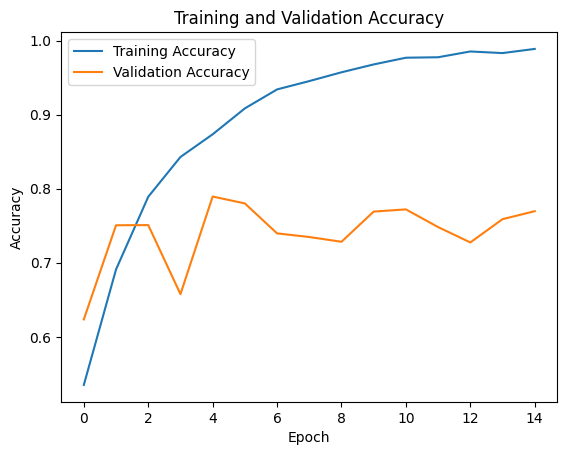

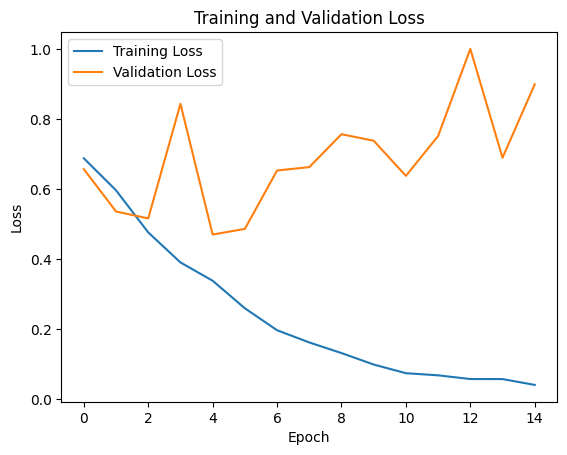

In [11]:
# Plot training and validation accuracy
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Mitigating sequence distortion and handling padding artifacts

### Applying input filtering at the embedding layer


In [12]:
in2 = keras.Input(shape=(None,), dtype="int64")
em2 = layers.Embedding(
    input_dim=MAX_VOCAB_SIZE, output_dim=256, mask_zero=True)(in2)
x = layers.Bidirectional(layers.LSTM(32))(em2)
x = layers.Dropout(0.5)(x)
output_layer2 = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(in2, output_layer2)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, None, 256) │  2,560,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, None)      │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 64)        │     73,984 │ embedding_3[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
checkpoint_callbacks2 = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                    save_best_only=True)
]
history2=model.fit(vectorized_train_review_dataset, validation_data= vectorized_validation_review_dataset, epochs=15, callbacks=checkpoint_callbacks2)


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.5305 - loss: 0.6894 - val_accuracy: 0.6287 - val_loss: 0.6467
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.6959 - loss: 0.5945 - val_accuracy: 0.7383 - val_loss: 0.5291
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.8035 - loss: 0.4462 - val_accuracy: 0.7768 - val_loss: 0.4893
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.8587 - loss: 0.3363 - val_accuracy: 0.6805 - val_loss: 0.6573
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.8920 - loss: 0.2686 - val_accuracy: 0.7923 - val_loss: 0.4774
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.9392 - loss: 0.1830 - val_accuracy: 0.6197 - val_loss: 1.1706
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.9524 - loss: 0.1412 - val_accuracy: 0.7804 - val_loss: 0.6370
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.9665 - loss: 0.1102 - val_acc

In [14]:

model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_review_dataset)[1]:.3f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7783 - loss: 0.4949
Test acc: 0.780


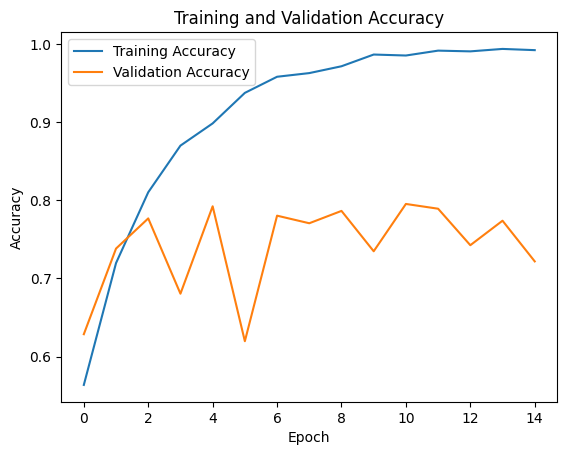

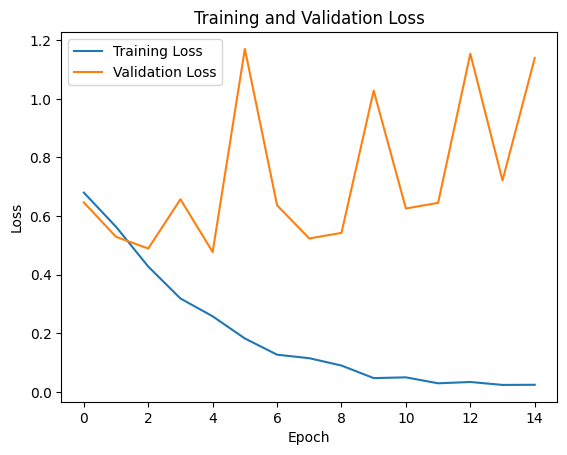

In [15]:
# Plot training and validation accuracy
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Utilizing Pretrained Word Embeddings

In [16]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-11-12 21:35:38--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-11-12 21:35:38--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-11-12 21:35:38--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

#### Interpreting a Single Word Using Word Embeddings

In [17]:
import numpy as np
GLOVE_FILE_PATH = "glove.6B.100d.txt"

glove_embeddings = {}
with open(GLOVE_FILE_PATH) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        glove_embeddings[word] = coefs

print(f"Found {len(glove_embeddings)} word vectors.")

Found 400000 word vectors.


#### Configuring the Embedding Matrix Using GloVe Vectors from the Official Source

In [18]:
em_dim = 100

vocab = text_vectorization_layer.get_vocabulary()
word_to_index = dict(zip(vocab, range(len(vocab))))

embedding_matrix = np.zeros((MAX_VOCAB_SIZE, em_dim))
for word, i in word_to_index.items():
    if i < MAX_VOCAB_SIZE:
        em_vector = glove_embeddings.get(word)
    if em_vector is not None:
        embedding_matrix[i] = em_vector

In [19]:
em_layer = layers.Embedding(
    MAX_VOCAB_SIZE,
    em_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

### Model Architecture with a Trainable Embedding Layer



In [20]:
in4 = keras.Input(shape=(None,), dtype="int64")
em4 = em_layer(in4)
x = layers.Bidirectional(layers.LSTM(32))(em4)
x = layers.Dropout(0.5)(x)
output_layer4 = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(in4, output_layer4)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, None, 100) │  1,000,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, None)      │          0 │ input_layer_3[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 64)        │     34,048 │ embedding_4[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,034,113 (3.94 MB)

 Trainable params: 34,113 (133.25 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [21]:
checkpoint_callbacks4 = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]

history4=model.fit(vectorized_train_review_dataset, validation_data= vectorized_validation_review_dataset, epochs=15, callbacks=checkpoint_callbacks4)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test Accuracy: {model.evaluate(int_test_review_dataset)[1]:.3f}")

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - accuracy: 0.5403 - loss: 0.6982 - val_accuracy: 0.6400 - val_loss: 0.6411
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.6559 - loss: 0.6351 - val_accuracy: 0.6670 - val_loss: 0.6281
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.6816 - loss: 0.6050 - val_accuracy: 0.7025 - val_loss: 0.5982
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.7198 - loss: 0.5687 - val_accuracy: 0.7283 - val_loss: 0.5486
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.7345 - loss: 0.5378 - val_accuracy: 0.7458 - val_loss: 0.5264
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.7470 - loss: 0.5127 - val_accuracy: 0.7589 - val_loss: 0.4982
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.7694 - loss: 0.4924 - val_accuracy: 0.7090 - val_loss: 0.6083
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.7859 - loss: 0.4747 - v

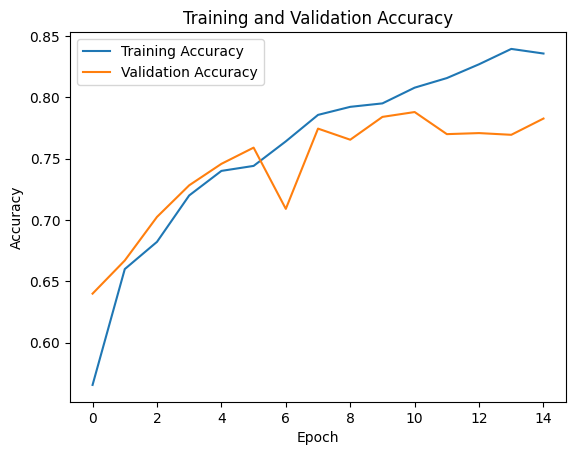

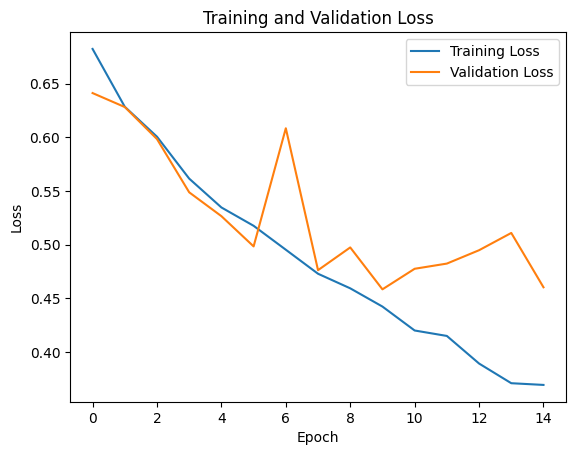

In [22]:
# Plot training and validation accuracy
plt.plot(history4.history['accuracy'], label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Found 5000 files belonging to 2 classes.
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.5109 - loss: 0.6929 - val_accuracy: 0.6562 - val_loss: 0.6481
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.6763 - loss: 0.6184 - val_accuracy: 0.7516 - val_loss: 0.5342
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.7973 - loss: 0.4762 - val_accuracy: 0.7758 - val_loss: 0.4835
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.8651 - loss: 0.3639 - val_accuracy: 0.6963 - val_loss: 0.6247
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.8857 - loss: 0.3112 - val_accuracy: 0.7624 - val_loss: 0.5800
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.9223 - loss: 0.2232 - val_accuracy: 0.7774 - val_loss: 0.4983
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9319 - loss: 0.1909 - val_accuracy: 0.6581 - val_loss: 0.9454
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - a

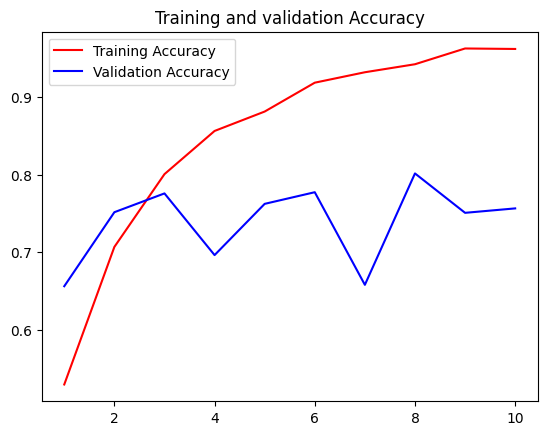

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.5219 - loss: 0.7079 - val_accuracy: 0.5877 - val_loss: 0.6708
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.6302 - loss: 0.6425 - val_accuracy: 0.6856 - val_loss: 0.6017
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.6983 - loss: 0.5866 - val_accuracy: 0.7091 - val_loss: 0.5718
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.7222 - loss: 0.5601 - val_accuracy: 0.6941 - val_loss: 0.5724
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.7389 - loss: 0.5303 - val_accuracy: 0.7592 - val_loss: 0.5048
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.7676 - loss: 0.4940 - val_accuracy: 0.7528 - val_loss: 0.5053
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.7697 - loss: 0.4756 - val_accuracy: 0.7429 - val_loss: 0.5156
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.7828 - loss: 0.4738 - v

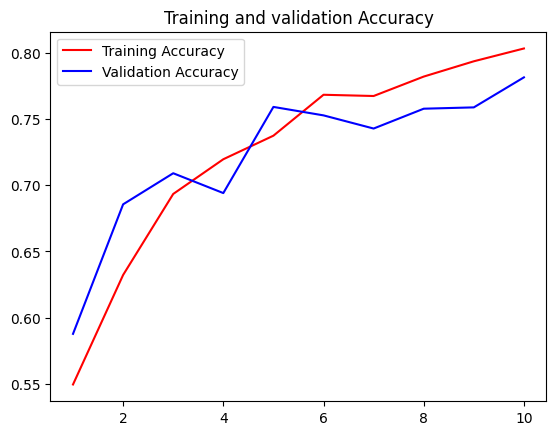

Training samples: 100
Embedding layer test accuracy: 0.775
Pretrained embeddings test accuracy: 0.775
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.5202 - loss: 0.6888 - val_accuracy: 0.6939 - val_loss: 0.6019
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.7438 - loss: 0.5478 - val_accuracy: 0.7650 - val_loss: 0.5024
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.8280 - loss: 0.4144 - val_accuracy: 0.6805 - val_loss: 0.6363
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8824 - loss: 0.3169 - val_accuracy: 0.8003 - val_loss: 0.4364
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.9132 - loss: 0.2633 - val_accuracy: 0.7401 - val_loss: 0.6810
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.9092 - loss: 0.2216 - val_accuracy: 0.8076 - val_loss: 0.4573
Epoch 7/10
157/157 ━━━━━━━━━━

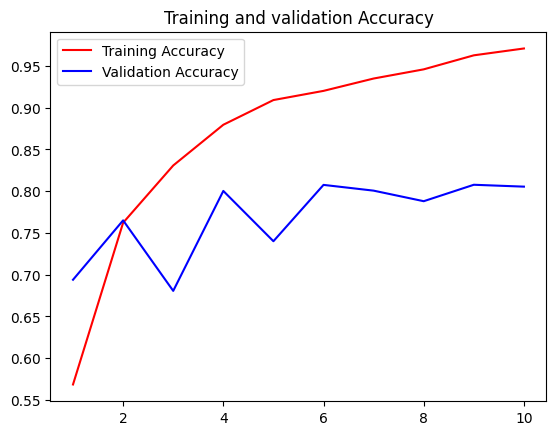

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.5507 - loss: 0.6856 - val_accuracy: 0.5678 - val_loss: 0.7008
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.6749 - loss: 0.6056 - val_accuracy: 0.7301 - val_loss: 0.5549
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.7310 - loss: 0.5503 - val_accuracy: 0.7498 - val_loss: 0.5185
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.7486 - loss: 0.5175 - val_accuracy: 0.7042 - val_loss: 0.5734
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.7673 - loss: 0.4878 - val_accuracy: 0.7674 - val_loss: 0.4917
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.7836 - loss: 0.4675 - val_accuracy: 0.7699 - val_loss: 0.4815
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.8005 - loss: 0.4410 - val_accuracy: 0.7655 - val_loss: 0.4861
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.8075 - loss: 0.4240 - val

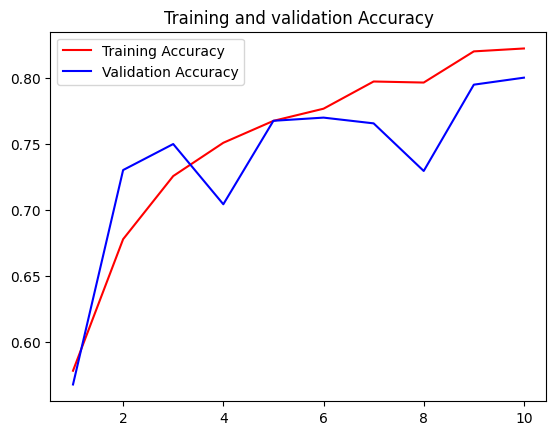

Training samples: 500
Embedding layer test accuracy: 0.791
Pretrained embeddings test accuracy: 0.800
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.5306 - loss: 0.6896 - val_accuracy: 0.6037 - val_loss: 0.6564
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.7105 - loss: 0.5853 - val_accuracy: 0.7520 - val_loss: 0.5171
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8139 - loss: 0.4364 - val_accuracy: 0.7613 - val_loss: 0.5066
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.8612 - loss: 0.3577 - val_accuracy: 0.8043 - val_loss: 0.4551
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.8810 - loss: 0.3025 - val_accuracy: 0.8030 - val_loss: 0.4430
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.9149 - loss: 0.2407 - val_accuracy: 0.8001 - val_loss: 0.4695
Epoch 7/10
157/157 ━━━━━━━━━━━━

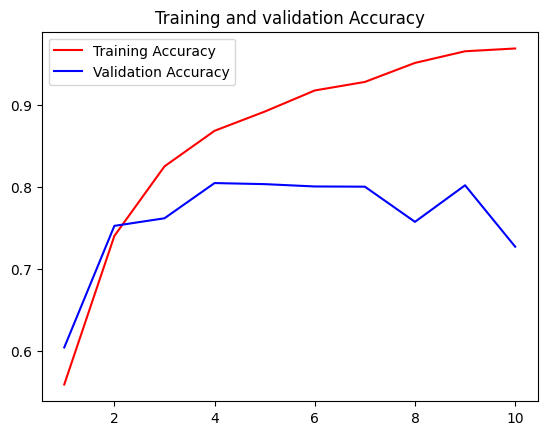

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.5465 - loss: 0.6924 - val_accuracy: 0.6736 - val_loss: 0.6117
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.6668 - loss: 0.6137 - val_accuracy: 0.6713 - val_loss: 0.6024
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.7172 - loss: 0.5612 - val_accuracy: 0.6418 - val_loss: 0.6313
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.7438 - loss: 0.5270 - val_accuracy: 0.7589 - val_loss: 0.5190
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.7603 - loss: 0.5082 - val_accuracy: 0.7693 - val_loss: 0.4830
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.7796 - loss: 0.4685 - val_accuracy: 0.7481 - val_loss: 0.5183
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - accuracy: 0.7916 - loss: 0.4611 - val_accuracy: 0.6478 - val_loss: 0.7070
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.7954 - loss: 0.4546 - va

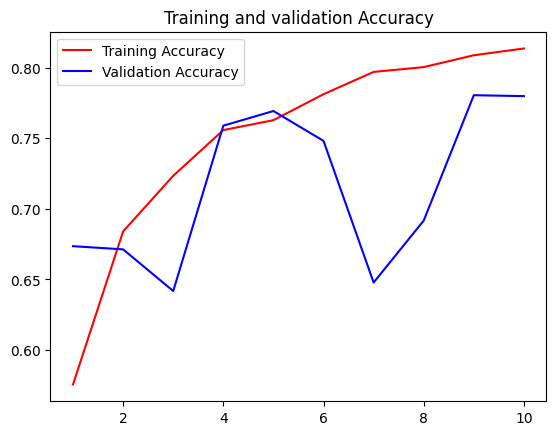

Training samples: 1000
Embedding layer test accuracy: 0.796
Pretrained embeddings test accuracy: 0.781
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.5185 - loss: 0.6923 - val_accuracy: 0.6232 - val_loss: 0.6570
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.6924 - loss: 0.6030 - val_accuracy: 0.7623 - val_loss: 0.5039
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - accuracy: 0.8094 - loss: 0.4455 - val_accuracy: 0.7735 - val_loss: 0.4788
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.8655 - loss: 0.3635 - val_accuracy: 0.8067 - val_loss: 0.4343
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.8916 - loss: 0.2940 - val_accuracy: 0.7827 - val_loss: 0.5271
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9096 - loss: 0.2470 - val_accuracy: 0.7484 - val_loss: 0.8807
Epoch 7/10
157/157 ━━━━━━━━━━

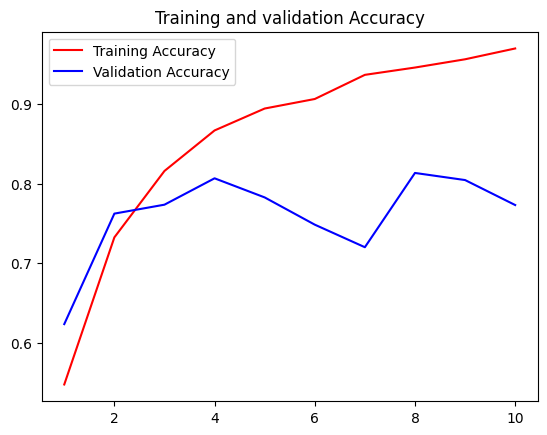

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.5365 - loss: 0.6923 - val_accuracy: 0.6338 - val_loss: 0.6422
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.6629 - loss: 0.6131 - val_accuracy: 0.6508 - val_loss: 0.6163
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.7081 - loss: 0.5668 - val_accuracy: 0.7509 - val_loss: 0.5184
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.7326 - loss: 0.5338 - val_accuracy: 0.7344 - val_loss: 0.5410
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.7554 - loss: 0.5034 - val_accuracy: 0.7687 - val_loss: 0.5020
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.7699 - loss: 0.4836 - val_accuracy: 0.7793 - val_loss: 0.4710
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.7859 - loss: 0.4624 - val_accuracy: 0.7343 - val_loss: 0.5602
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - accuracy: 0.8036 - loss: 0.4357 - val

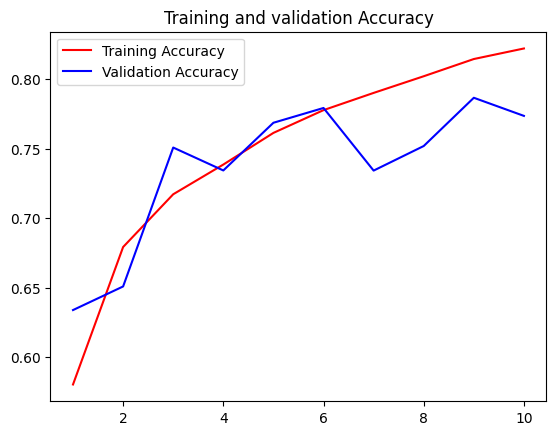

Training samples: 5000
Embedding layer test accuracy: 0.804
Pretrained embeddings test accuracy: 0.786
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.5215 - loss: 0.6918 - val_accuracy: 0.6913 - val_loss: 0.6317
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.7056 - loss: 0.5903 - val_accuracy: 0.7548 - val_loss: 0.5285
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8197 - loss: 0.4432 - val_accuracy: 0.7150 - val_loss: 0.7396
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.8656 - loss: 0.3583 - val_accuracy: 0.7573 - val_loss: 0.5595
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.8902 - loss: 0.2871 - val_accuracy: 0.7646 - val_loss: 0.5833
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.9176 - loss: 0.2310 - val_accuracy: 0.7695 - val_loss: 0.7087
Epoch 7/10
157/157 ━━━━━━━━━━━

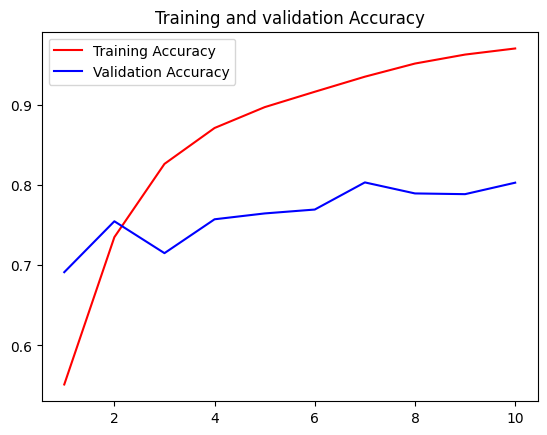

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.5526 - loss: 0.6832 - val_accuracy: 0.6782 - val_loss: 0.6085
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.6831 - loss: 0.5998 - val_accuracy: 0.5542 - val_loss: 0.7899
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.7153 - loss: 0.5596 - val_accuracy: 0.7065 - val_loss: 0.5608
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - accuracy: 0.7477 - loss: 0.5179 - val_accuracy: 0.7220 - val_loss: 0.5407
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.7735 - loss: 0.4874 - val_accuracy: 0.7556 - val_loss: 0.5175
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.7821 - loss: 0.4698 - val_accuracy: 0.7804 - val_loss: 0.4609
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.7983 - loss: 0.4422 - val_accuracy: 0.7110 - val_loss: 0.5899
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.8044 - loss: 0.4314 - val

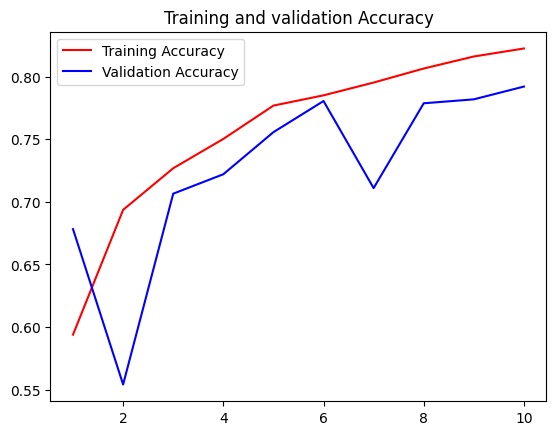

Training samples: 10000
Embedding layer test accuracy: 0.747
Pretrained embeddings test accuracy: 0.794
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.5085 - loss: 0.6919 - val_accuracy: 0.6840 - val_loss: 0.6288
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.7150 - loss: 0.5884 - val_accuracy: 0.7745 - val_loss: 0.4938
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.8072 - loss: 0.4578 - val_accuracy: 0.7878 - val_loss: 0.4689
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.8595 - loss: 0.3578 - val_accuracy: 0.7992 - val_loss: 0.5141
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.8973 - loss: 0.2743 - val_accuracy: 0.8218 - val_loss: 0.4589
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9080 - loss: 0.2633 - val_accuracy: 0.8001 - val_loss: 0.4532
Epoch 7/10
157/157 ━━━━━━━━━━

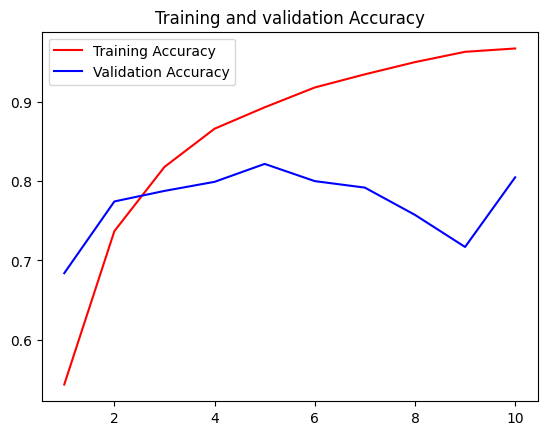

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.5398 - loss: 0.6990 - val_accuracy: 0.6459 - val_loss: 0.6326
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.6648 - loss: 0.6083 - val_accuracy: 0.6796 - val_loss: 0.6059
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.7180 - loss: 0.5596 - val_accuracy: 0.5920 - val_loss: 0.6285
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.7407 - loss: 0.5280 - val_accuracy: 0.7668 - val_loss: 0.4948
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.7569 - loss: 0.4898 - val_accuracy: 0.7440 - val_loss: 0.5213
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.7940 - loss: 0.4566 - val_accuracy: 0.7501 - val_loss: 0.5535
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.8014 - loss: 0.4394 - val_accuracy: 0.7682 - val_loss: 0.4852
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.8047 - loss: 0.4250 - val_

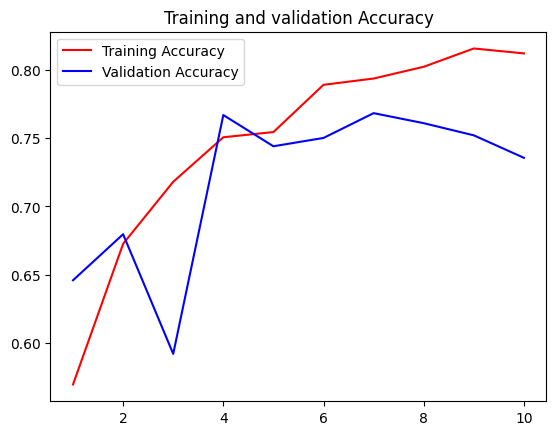

Training samples: 20000
Embedding layer test accuracy: 0.789
Pretrained embeddings test accuracy: 0.766
--------------------------------------------------


In [23]:
train_sample_sizes = [100, 500, 1000, 5000, 10000, 20000]
for train_size in train_sample_sizes:
    train_review_dataset = keras.utils.text_dataset_from_directory(
        "aclImdb/train", batch_size=batch_size
    ).take(train_size)

    int_train_review_dataset = train_review_dataset.map(
        lambda x, y: (text_vectorization_layer(x), y),
        num_parallel_calls=4
    )
    int_validation_review_dataset = validation_review_dataset.map(
        lambda x, y: (text_vectorization_layer(x), y),
        num_parallel_calls=4
    )
    int_test_review_dataset = test_review_dataset.map(
        lambda x, y: (text_vectorization_layer(x), y),
        num_parallel_calls=4
    )

    # Train and evaluate the model with the embedding layer
    embedding_layer = layers.Embedding(MAX_VOCAB_SIZE, em_dim)

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
        keras.callbacks.ModelCheckpoint("embeddings_model.keras", save_best_only=True)
    ]
    history = model.fit(int_train_review_dataset, validation_data=int_validation_review_dataset, epochs=10, callbacks=callbacks)
    model = keras.models.load_model("embeddings_model.keras")
    embedding_layer_test_acc = model.evaluate(int_test_review_dataset)[1]

    loss = history.history["accuracy"]
    val_loss = history.history["val_accuracy"]
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, "r", label="Training Accuracy")
    plt.plot(epochs, val_loss, "b", label="Validation Accuracy")
    plt.title("Training and validation Accuracy")
    plt.legend()
    plt.show()

    # Train and evaluate the model with the pretrained word embeddings
    embedding_layer = layers.Embedding(
        MAX_VOCAB_SIZE,
        em_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
        mask_zero=True,
    )

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
        keras.callbacks.ModelCheckpoint("pretrained_embeddings_model.keras", save_best_only=True)
    ]
    history = model.fit(int_train_review_dataset, validation_data=int_validation_review_dataset, epochs=10, callbacks=callbacks)
    model = keras.models.load_model("pretrained_embeddings_model.keras")
    pretrained_embeddings_test_acc = model.evaluate(int_test_review_dataset)[1]

    loss = history.history["accuracy"]
    val_loss = history.history["val_accuracy"]
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, "r", label="Training Accuracy")
    plt.plot(epochs, val_loss, "b", label="Validation Accuracy")
    plt.title("Training and validation Accuracy")
    plt.legend()
    plt.show()

    # Compare the performance and store the results
    print(f"Training samples: {train_size}")
    print(f"Embedding layer test accuracy: {embedding_layer_test_acc:.3f}")
    print(f"Pretrained embeddings test accuracy: {pretrained_embeddings_test_acc:.3f}")
    print("-" * 50)




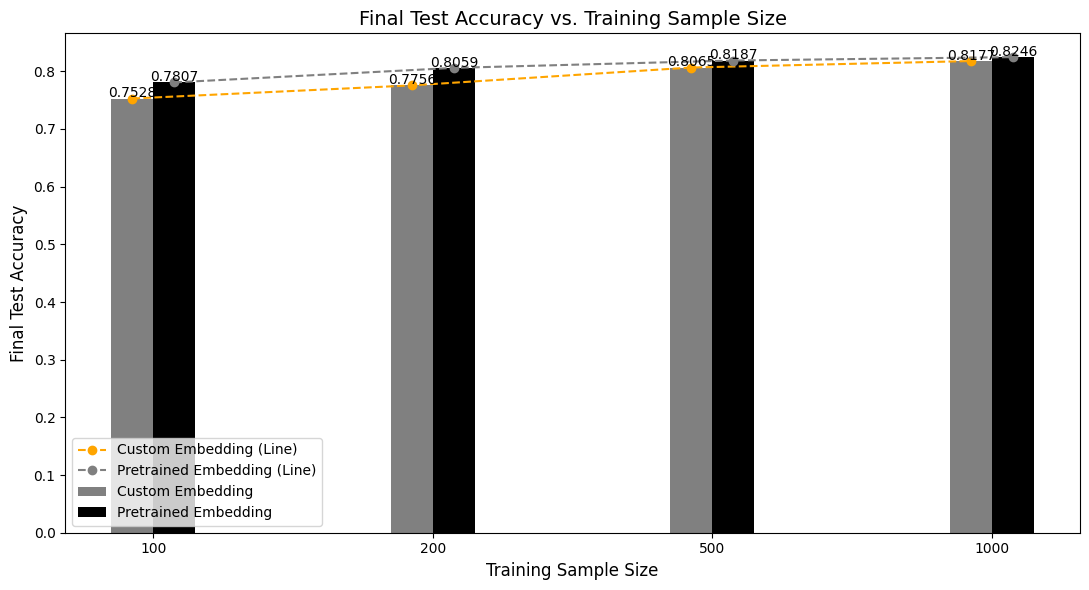

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Data
sample_sizes = [100, 200, 500, 1000]
embedding_accuracies = [0.75280, 0.77556, 0.80652, 0.81772]  # Replace with actual final values
pretrained_accuracies = [0.78072, 0.80588, 0.81868, 0.82456]  # Replace with actual final values

# Bar width and positions
bar_width = 0.15
x_indices = np.arange(len(sample_sizes))  # Base positions for bars

# Plot bars
plt.figure(figsize=(11, 6))
plt.bar(x_indices - bar_width / 2, embedding_accuracies,
        width=bar_width, label='Custom Embedding', color='grey')
plt.bar(x_indices + bar_width / 2, pretrained_accuracies,
        width=bar_width, label='Pretrained Embedding', color='black')

# Overlay lines for comparison
plt.plot(x_indices - bar_width / 2, embedding_accuracies,
         marker='o', color='orange', linestyle='--', label='Custom Embedding (Line)')
plt.plot(x_indices + bar_width / 2, pretrained_accuracies,
         marker='o', color='grey', linestyle='--', label='Pretrained Embedding (Line)')

# Add labels and title
plt.xlabel('Training Sample Size', fontsize=12)
plt.ylabel('Final Test Accuracy', fontsize=12)
plt.title('Final Test Accuracy vs. Training Sample Size', fontsize=14)
plt.xticks(x_indices, sample_sizes)  # Use sample sizes as x-tick labels
plt.legend()

# Annotate bars with final accuracy values
for i in range(len(sample_sizes)):
    plt.text(x_indices[i] - bar_width / 2, embedding_accuracies[i] + 0.002,
             f'{embedding_accuracies[i]:.4f}', ha='center', fontsize=10)
    plt.text(x_indices[i] + bar_width / 2, pretrained_accuracies[i] + 0.002,
             f'{pretrained_accuracies[i]:.4f}', ha='center', fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
